In [ ]:
!git clone https://github.com/Ro6ertWcislo/AutoESN.git
!unzip /content/drive/MyDrive/pjm.zip
!unzip chick.zip
!pip install optuna

fatal: destination path 'AutoESN' already exists and is not an empty directory.
Archive:  /content/drive/MyDrive/pjm.zip
replace AEP_hourly.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  chick.zip
replace hungary_chickenpox.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: optuna in /usr/local/lib/python3.10/dist-packages (3.5.0)
ERROR: Operation cancelled by user


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.seasonal import seasonal_decompose
import optuna
import torch
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error
import math

from auto_esn.esn.esn import GroupedDeepESN
from auto_esn.esn.reservoir.activation import self_normalizing_default
from auto_esn.esn.reservoir.util import NRMSELoss
from auto_esn.esn.reservoir.initialization import CompositeInitializer, WeightInitializer
from auto_esn.esn.reservoir.util import NRMSELoss

nrmse = NRMSELoss()

In [ ]:
def prepare_mg(mg):
    mg['date'] = pd.date_range(start="01-01-2000", periods=mg.shape[0], freq="D")
    mg.set_index('date', inplace = True)
    mg_train = mg[mg.index.year<2020]

    mg_val = mg[mg.index.year>=2020]


    columns_to_normalize = mg.columns
    scaler = MinMaxScaler()
    mg_train[columns_to_normalize] = scaler.fit_transform(mg_train[columns_to_normalize].values)
    mg_val[columns_to_normalize] = scaler.transform(mg_val[columns_to_normalize.values])
    return mg_train, mg_val, mg

In [ ]:
def prepare_chickenpox(chick_df):
    chick_df  = chick_df[['Date','BUDAPEST']]
    chick_df['Date'] = pd.to_datetime(chick_df["Date"])
    chick_df.rename(columns = {'Datetime':'date', 'BUDAPEST':'y'}, inplace = True)
    chick_df.set_index('Date', inplace = True)
    chick_train = chick_df[chick_df.index.year<2012]

    chick_val = chick_df[chick_df.index.year>=2012]


    columns_to_normalize = chick_df.columns
    scaler = MinMaxScaler()
    chick_train[columns_to_normalize] = scaler.fit_transform(chick_train[columns_to_normalize].values)
    chick_val[columns_to_normalize] = scaler.transform(chick_val[columns_to_normalize].values)
    return chick_train, chick_val, chick_df

In [ ]:
def prepare_electricity(electricity_df):
    electricity_df.rename(columns = {'Datetime':'date'}, inplace = True)
    electricity_df.drop_duplicates(subset = 'date')
    electricity_df['y'] = electricity_df.groupby('date')['PJME_MW'].transform('sum')
    electricity_df['date'] = pd.to_datetime(electricity_df["date"])
    electricity_df.drop_duplicates(subset = ['date'],inplace=True)
    # el.drop(columns = ['date', 'time'], inplace = True)
    electricity_df.set_index('date', inplace = True)
    electricity_df = electricity_df[electricity_df.index.year>2014]
    el_train = electricity_df[electricity_df.index.year<2017]
    el_val = electricity_df[electricity_df.index.year>=2017]

    columns_to_normalize = electricity_df.columns
    scaler = MinMaxScaler()
    el_train[columns_to_normalize] = scaler.fit_transform(el_train[columns_to_normalize].values)
    el_val[columns_to_normalize] = scaler.transform(el_val[columns_to_normalize].values)

    return el_train, el_val, electricity_df

In [ ]:
electricity = pd.read_csv('PJME_hourly.csv')
el_train, el_val, el = prepare_electricity(electricity)

<ipython-input-144-25fc6c10cc50>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  el_train[columns_to_normalize] = scaler.fit_transform(el_train[columns_to_normalize].values)
<ipython-input-144-25fc6c10cc50>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  el_val[columns_to_normalize] = scaler.transform(el_val[columns_to_normalize].values)


In [ ]:
mg = pd.read_csv('mg.csv')
mg_train, mg_val, mg = prepare_mg(mg)

<ipython-input-142-bca2c14d3656>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mg_train[columns_to_normalize] = scaler.fit_transform(mg_train[columns_to_normalize].values)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
<ipython-input-142-bca2c14d3656>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mg_val[columns_to_normalize] = scaler.transform(mg_val[columns_to_normalize.values])


In [ ]:
mg

,y
date,
2000-01-01,1.200000
2000-01-02,1.188060
2000-01-03,1.176238
2000-01-04,1.164535
2000-01-05,1.152947
...,...
2027-05-15,0.965385
2027-05-16,0.964666
2027-05-17,0.963985


In [ ]:
data = pd.read_csv('hungary_chickenpox.csv')
data.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [ ]:
chick_train, chick_val, chick = prepare_chickenpox(data)

<ipython-input-143-f3dcbb1b6669>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  chick_df['Date'] = pd.to_datetime(chick_df["Date"])
<ipython-input-143-f3dcbb1b6669>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chick_df['Date'] = pd.to_datetime(chick_df["Date"])
<ipython-input-143-f3dcbb1b6669>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chick_df.rename(columns = {'Datetime':'date', 'BUDAPEST':'y'}, inplace = 

In [ ]:
mg_train.y

date
2000-01-01    0.896060
2000-01-02    0.885151
2000-01-03    0.874351
2000-01-04    0.863658
2000-01-05    0.853071
                ...   
2019-12-27    0.493877
2019-12-28    0.490816
2019-12-29    0.487821
2019-12-30    0.484893
2019-12-31    0.482034
Name: y, Length: 7305, dtype: float64

In [ ]:
chick_train.y

Date
2005-03-01    0.348008
2005-10-01    0.324948
2005-01-17    0.197065
2005-01-24    0.337526
2005-01-31    0.251572
                ...   
2011-11-28    0.169811
2011-05-12    0.228512
2011-12-12    0.186583
2011-12-19    0.337526
2011-12-26    0.054507
Name: y, Length: 365, dtype: float64

In [ ]:
def data_to_torch(data):
    a = np.array(data)
    return torch.from_numpy(a).to(dtype=torch.float32)

In [ ]:
def best_deepesn_initializer(seed):
    # initialize input weights with uniform distribution from -1 to 1 and specified seed to reproduce results
    input_weight = CompositeInitializer().with_seed(seed).uniform()

    reservoir_weight = CompositeInitializer() \
        .with_seed(seed) \
        .uniform() \
        .sparse(density=0.1) \
        .spectral_normalize() \
        .scale(factor=1.0)  # unnecesary but i wanted to make it explicit

    return WeightInitializer(weight_ih_init=input_weight, weight_hh_init=reservoir_weight)

In [ ]:
def convert_data_to_torch(train, val):
    train_X, train_y = data_to_torch(train['y'].values[:-1]), data_to_torch(train['y'].values[1:])
    test_X, test_y = data_to_torch(val['y'].values[:-1]), data_to_torch(val['y'].values[1:])
    X, X_test, y, y_test = train_X, test_X, train_y, test_y

    X = torch.reshape(X, (X.shape[0],1))
    y = torch.reshape(y, (y.shape[0],1))

    X_test = torch.reshape(X_test, (X_test.shape[0],1))
    y_test = torch.reshape(y_test, (y_test.shape[0],1))

    return X, y, X_test, y_test

In [ ]:
def get_activation(leaky_rate = 1., radius = 120.):
    return self_normalizing_default(leaky_rate=leaky_rate, spectral_radius=radius)

In [ ]:
def get_esn(activation, input_size = 6, groups = 3, groups_def = (2,2,2), hidden_size =100, seed = 70):
    esn = GroupedDeepESN(
        input_size=input_size,
        groups=groups,
        num_layers=groups_def,
        hidden_size=hidden_size,
        initializer=best_deepesn_initializer(seed),
        activation=activation
    )
    return esn

In [ ]:
def run_optuna_study(train_X, train_y, test_X, test_y, past_steps, n_iters):
    def objective(trial):
        activation = get_activation(
            leaky_rate = trial.suggest_float("leaky_rate", 0.85, 1.2),
            radius = trial.suggest_int("spectral radius", 100,800))
        esn = get_esn(activation, input_size = past_steps, hidden_size = trial.suggest_int("hidden_size",100,550))
        esn.fit(train_X, train_y)
        output = esn(test_X)
        return nrmse(output, test_y).item()

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_iters)
    return study.best_params

In [ ]:
def get_data_one_ahead(dataset, past, future):
    # print(datasets[dataset])
    train_X, train_y, val_X, val_y = datasets[dataset]['data'][0],datasets[dataset]['data'][1], datasets[dataset]['data'][2], datasets[dataset]['data'][3]
    return train_X, train_y, val_X, val_y

In [ ]:
datasets = {
    'chickenpox': {
        'data': convert_data_to_torch(chick_train, chick_val),
        'df_train':chick_train,
        'df_val':chick_val,
        'input_length':12,
        'future_length':8,
        'optuna_iters':150
    },
    'mackey-glass': {
        'data':convert_data_to_torch(mg_train, mg_val),
        'df_train':mg_train,
        'df_val':mg_val,
        'input_length':100,
        'future_length':40,
        'optuna_iters':150,
    },
    'electricity': {
        'df_train':el_train,
        'df_val': el_val,
        'data': convert_data_to_torch(el_train, el_val),
        'input_length':20*24,
        'future_length':7*24,
        'optuna_iters':150,
    }
}

One step ahead prediction

[I 2024-02-02 16:35:42,691] A new study created in memory with name: no-name-ac7f2fe7-31ae-4a61-912c-05ae79044ea5


chickenpox


[I 2024-02-02 16:35:44,260] Trial 0 finished with value: 1.0776872634887695 and parameters: {'leaky_rate': 1.1194677607907182, 'spectral radius': 138, 'hidden_size': 136}. Best is trial 0 with value: 1.0776872634887695.
[I 2024-02-02 16:35:45,651] Trial 1 finished with value: 0.9516021013259888 and parameters: {'leaky_rate': 1.0007842301328598, 'spectral radius': 180, 'hidden_size': 463}. Best is trial 1 with value: 0.9516021013259888.
[I 2024-02-02 16:35:46,518] Trial 2 finished with value: 0.9251583218574524 and parameters: {'leaky_rate': 0.9254970982956056, 'spectral radius': 428, 'hidden_size': 354}. Best is trial 2 with value: 0.9251583218574524.
[I 2024-02-02 16:35:47,825] Trial 3 finished with value: 1.0207860469818115 and parameters: {'leaky_rate': 0.9886317380934178, 'spectral radius': 324, 'hidden_size': 411}. Best is trial 2 with value: 0.9251583218574524.
[I 2024-02-02 16:35:51,727] Trial 4 finished with value: 0.9823154211044312 and parameters: {'leaky_rate': 1.19132569569

{'leaky_rate': 0.9233655965616284, 'spectral radius': 411, 'hidden_size': 443}
torch.Size([156, 1])


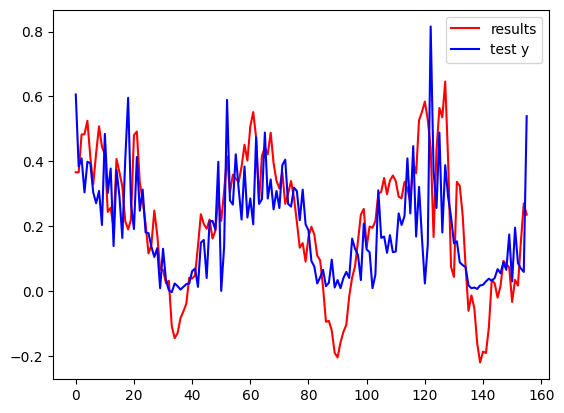

[I 2024-02-02 16:38:42,485] A new study created in memory with name: no-name-0743c94d-28b2-4b5e-acee-3990e322111d


value of nrmse metric:  0.7582698464393616
mse :  0.023299886
mape :  0.7401413
rmse :  0.15264300152227636
mackey-glass


[I 2024-02-02 16:39:12,097] Trial 0 finished with value: 0.001866943552158773 and parameters: {'leaky_rate': 1.1987577164756151, 'spectral radius': 744, 'hidden_size': 447}. Best is trial 0 with value: 0.001866943552158773.
[I 2024-02-02 16:39:22,378] Trial 1 finished with value: 0.0008303709328174591 and parameters: {'leaky_rate': 0.9295473460033312, 'spectral radius': 185, 'hidden_size': 118}. Best is trial 1 with value: 0.0008303709328174591.
[I 2024-02-02 16:39:33,884] Trial 2 finished with value: 0.0008297308231703937 and parameters: {'leaky_rate': 1.1647997865853643, 'spectral radius': 532, 'hidden_size': 161}. Best is trial 2 with value: 0.0008297308231703937.
[I 2024-02-02 16:39:45,008] Trial 3 finished with value: 0.0017394819296896458 and parameters: {'leaky_rate': 1.1321895416911048, 'spectral radius': 208, 'hidden_size': 159}. Best is trial 2 with value: 0.0008297308231703937.
[I 2024-02-02 16:39:56,023] Trial 4 finished with value: 0.0018363876733928919 and parameters: {'l

{'leaky_rate': 0.9361268690461746, 'spectral radius': 502, 'hidden_size': 413}
torch.Size([2695, 1])


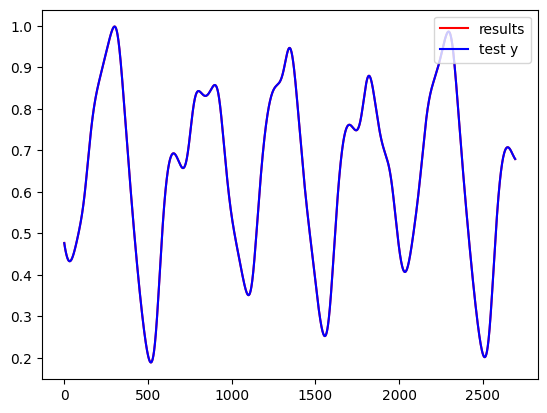

[I 2024-02-02 17:48:21,892] A new study created in memory with name: no-name-c10d9a4f-2aa4-4b5f-b81c-37903b147f1e


value of nrmse metric:  0.00034846647758968174
mse :  5.5525815e-09
mape :  9.6205426e-05
rmse :  7.451564604629493e-05
electricity


[I 2024-02-02 17:49:06,892] Trial 0 finished with value: 0.1397411823272705 and parameters: {'leaky_rate': 0.9578164187983311, 'spectral radius': 584, 'hidden_size': 285}. Best is trial 0 with value: 0.1397411823272705.
[I 2024-02-02 17:50:31,930] Trial 1 finished with value: 0.14289166033267975 and parameters: {'leaky_rate': 0.8530595346134892, 'spectral radius': 246, 'hidden_size': 495}. Best is trial 0 with value: 0.1397411823272705.
[I 2024-02-02 17:51:02,483] Trial 2 finished with value: 0.17988096177577972 and parameters: {'leaky_rate': 1.189147794673476, 'spectral radius': 569, 'hidden_size': 129}. Best is trial 0 with value: 0.1397411823272705.
[I 2024-02-02 17:52:22,610] Trial 3 finished with value: 0.1425991952419281 and parameters: {'leaky_rate': 0.8509358509429268, 'spectral radius': 155, 'hidden_size': 475}. Best is trial 0 with value: 0.1397411823272705.
[I 2024-02-02 17:53:41,566] Trial 4 finished with value: 0.14230631291866302 and parameters: {'leaky_rate': 1.102647396

{'leaky_rate': 0.9865405713692401, 'spectral radius': 411, 'hidden_size': 531}
torch.Size([13894, 1])


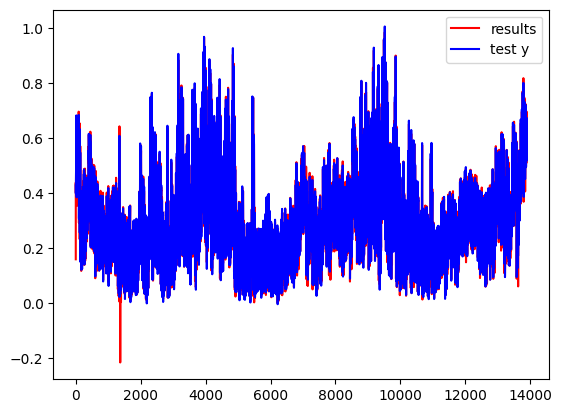

value of nrmse metric:  0.1338862031698227
mse :  0.00048377184
mape :  0.062447987
rmse :  0.021994814031979736


In [ ]:
for dataset in datasets:
    print(dataset)
    past_steps, future_steps = 1, 1
    train_X, train_y, test_X, test_y = get_data_one_ahead(dataset, past_steps, future_steps)

    study_best_params = run_optuna_study(train_X, train_y, test_X, test_y, past_steps, datasets[dataset]['optuna_iters'])
    print(study_best_params)
    esn = get_esn(get_activation(leaky_rate = study_best_params['leaky_rate'],
                                radius = study_best_params['spectral radius']),
                hidden_size = study_best_params['hidden_size'], input_size = past_steps)
    esn.fit(train_X, train_y)
    output = esn(test_X)
    print(output.shape)
    last = output.shape[0]
    plt.plot(range(last), output.view(-1).detach().numpy()[-last:], 'r', label = 'results')
    plt.plot(range(last), test_y.view(-1).detach().numpy()[-last:], 'b', label = 'test y')
    leg = plt.legend(loc='upper right')
    plt.show()

    print('value of nrmse metric: ', nrmse(output, test_y).item())
    print('mse : ', mean_squared_error(output, test_y))
    print('mape : ', mean_absolute_percentage_error(output, test_y))
    print('rmse : ',  math.sqrt(mean_squared_error(output, test_y)))

Many steps ahead prediction

In [ ]:
def get_data(df_train, df_val, past_steps, steps_ahead):
    train_y, train_X, test_y, test_X = [], [],[],[]
    for i in range(past_steps, len(df_train)-steps_ahead):
        train_y.append(df_train['y'].values[i+1:i+steps_ahead+1])
        train_X.append(df_train['y'].values[i-past_steps:i])

    for i in range(past_steps, len(df_val)-steps_ahead):
        test_y.append(df_val['y'].values[i+1:i+steps_ahead+1])
        test_X.append(df_val['y'].values[i-past_steps:i])

    train_y = data_to_torch(np.array(train_y))
    train_X = data_to_torch(np.array(train_X))
    test_y = data_to_torch(np.array(test_y))
    test_X = data_to_torch(np.array(test_X))
    return train_X, train_y, test_X, test_y

[I 2024-02-02 21:12:13,586] A new study created in memory with name: no-name-b7df7044-a9cc-4e87-a5f9-0ad5c2765140


chickenpox


[I 2024-02-02 21:12:14,081] Trial 0 finished with value: 1.1541008949279785 and parameters: {'leaky_rate': 0.929886131496283, 'spectral radius': 188, 'hidden_size': 142}. Best is trial 0 with value: 1.1541008949279785.
[I 2024-02-02 21:12:14,599] Trial 1 finished with value: 0.970885694026947 and parameters: {'leaky_rate': 1.0795893754965036, 'spectral radius': 354, 'hidden_size': 195}. Best is trial 1 with value: 0.970885694026947.
[I 2024-02-02 21:12:15,343] Trial 2 finished with value: 1.0660154819488525 and parameters: {'leaky_rate': 0.8516570513913377, 'spectral radius': 735, 'hidden_size': 323}. Best is trial 1 with value: 0.970885694026947.
[I 2024-02-02 21:12:16,353] Trial 3 finished with value: 1.034414291381836 and parameters: {'leaky_rate': 0.9543913784097457, 'spectral radius': 239, 'hidden_size': 418}. Best is trial 1 with value: 0.970885694026947.
[I 2024-02-02 21:12:17,687] Trial 4 finished with value: 1.00698721408844 and parameters: {'leaky_rate': 1.1116266675968702, '

{'leaky_rate': 0.971276401171894, 'spectral radius': 456, 'hidden_size': 485}
torch.Size([137, 8])


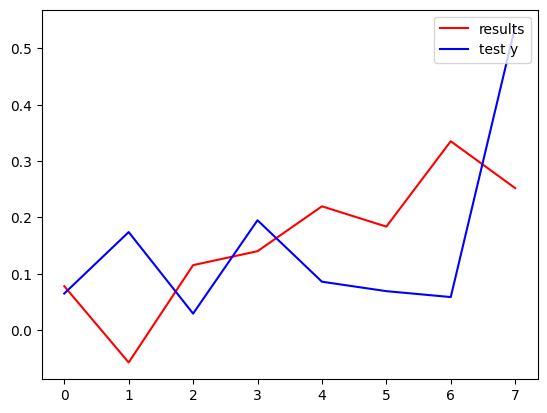

[I 2024-02-02 21:15:17,807] A new study created in memory with name: no-name-c5c63b31-4ad4-4e4d-8177-cee5473c39c4


value of nrmse metric:  0.9267978668212891
mse :  0.08847133
mape :  2.3129814
rmse :  0.2974413063148843
mackey-glass


[I 2024-02-02 21:15:54,331] Trial 0 finished with value: 0.0952410027384758 and parameters: {'leaky_rate': 1.082724163651977, 'spectral radius': 172, 'hidden_size': 480}. Best is trial 0 with value: 0.0952410027384758.
[I 2024-02-02 21:16:22,640] Trial 1 finished with value: 0.09788059443235397 and parameters: {'leaky_rate': 1.1433719018632478, 'spectral radius': 121, 'hidden_size': 417}. Best is trial 0 with value: 0.0952410027384758.
[I 2024-02-02 21:16:32,499] Trial 2 finished with value: 0.38496848940849304 and parameters: {'leaky_rate': 1.0819371068362709, 'spectral radius': 641, 'hidden_size': 126}. Best is trial 0 with value: 0.0952410027384758.
[I 2024-02-02 21:16:43,590] Trial 3 finished with value: 0.2770109474658966 and parameters: {'leaky_rate': 1.146601902600081, 'spectral radius': 598, 'hidden_size': 182}. Best is trial 0 with value: 0.0952410027384758.
[I 2024-02-02 21:17:02,332] Trial 4 finished with value: 0.37032172083854675 and parameters: {'leaky_rate': 1.0285162660

{'leaky_rate': 0.8821650446028881, 'spectral radius': 155, 'hidden_size': 485}
torch.Size([2556, 40])


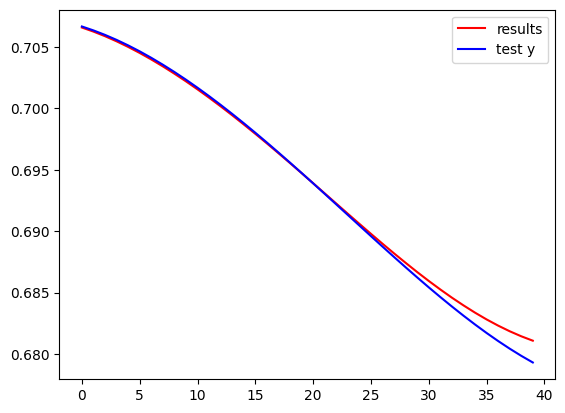

value of nrmse metric:  0.03306810185313225
mse :  5.122596e-05
mape :  0.0045730537
rmse :  0.007157231393150259
electricity


[I 2024-02-02 22:26:46,410] A new study created in memory with name: no-name-22a107f0-2662-4ef8-939a-4f6b66789202
[I 2024-02-02 22:27:16,148] Trial 0 finished with value: 0.7281110286712646 and parameters: {'leaky_rate': 0.9400786329538917, 'spectral radius': 198, 'hidden_size': 103}. Best is trial 0 with value: 0.7281110286712646.
[I 2024-02-02 22:28:19,775] Trial 1 finished with value: 0.732153058052063 and parameters: {'leaky_rate': 0.9624854085538194, 'spectral radius': 432, 'hidden_size': 360}. Best is trial 0 with value: 0.7281110286712646.
[I 2024-02-02 22:29:46,872] Trial 2 finished with value: 0.7336668968200684 and parameters: {'leaky_rate': 1.101200342300132, 'spectral radius': 604, 'hidden_size': 469}. Best is trial 0 with value: 0.7281110286712646.
[I 2024-02-02 22:31:35,310] Trial 3 finished with value: 0.7481593489646912 and parameters: {'leaky_rate': 1.0495536043333702, 'spectral radius': 690, 'hidden_size': 536}. Best is trial 0 with value: 0.7281110286712646.
[I 2024-

{'leaky_rate': 0.9464288413825308, 'spectral radius': 123, 'hidden_size': 222}
torch.Size([13247, 168])


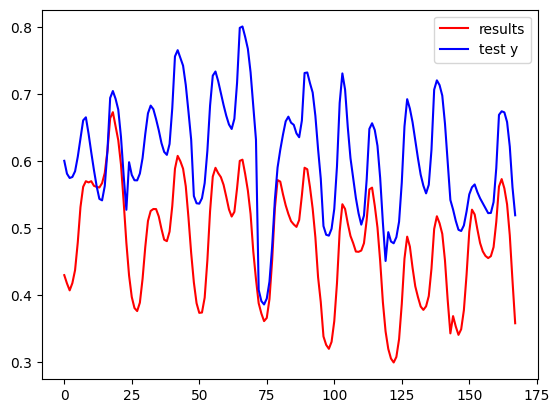

value of nrmse metric:  0.7103055715560913
mse :  0.010888417
mape :  0.72742635
rmse :  0.10434757903951629


In [ ]:
for dataset in datasets:
    print(dataset)

    df_train, df_val = datasets[dataset]['df_train'], datasets[dataset]['df_val']
    past_steps, future_steps = datasets[dataset]['input_length'], datasets[dataset]['future_length']
    train_X, train_y, test_X, test_y = get_data(df_train, df_val, past_steps, future_steps)
    study_best_params = run_optuna_study(train_X, train_y, test_X, test_y, past_steps, datasets[dataset]['optuna_iters'])

    print(study_best_params)
    esn = get_esn(get_activation(leaky_rate = study_best_params['leaky_rate'],
                                radius = study_best_params['spectral radius']),
                hidden_size = study_best_params['hidden_size'], input_size = past_steps)
    esn.fit(train_X, train_y)
    output = esn(test_X)

    print(output.shape)
    last = output.shape[1]
    plt.plot(range(last), output.view(-1).detach().numpy()[-last:], 'r', label = 'results')
    plt.plot(range(last), test_y.view(-1).detach().numpy()[-last:], 'b', label = 'test y')
    leg = plt.legend(loc='upper right')
    plt.show()

    print('value of nrmse metric: ', nrmse(output, test_y).item())
    print('mse : ', mean_squared_error(output, test_y))
    print('mape : ', mean_absolute_percentage_error(output, test_y))
    print('rmse : ',  math.sqrt(mean_squared_error(output, test_y)))